In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

Начальная точка: (250, 250), Порог: 20


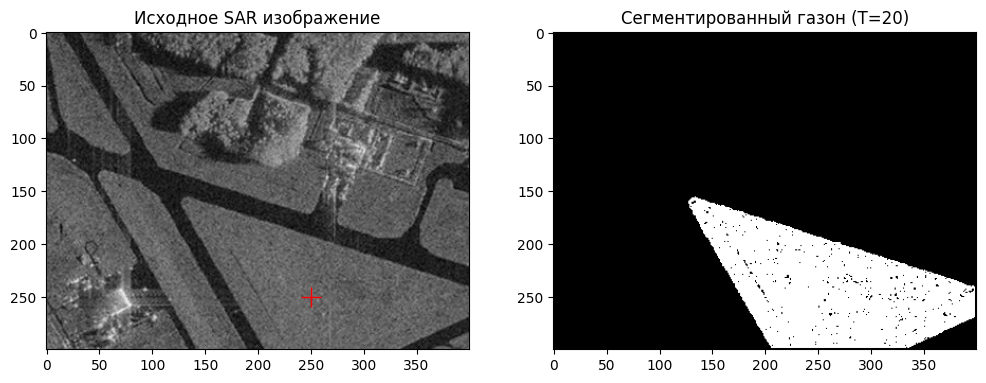

In [2]:
def homo_average(img, mask, point, T):
    if np.count_nonzero(img[mask > 0]) == 0:
        return True 
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
    if abs(av_val - img[point]) <= T:
        return True
    return False

def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    if seed_point[0] < 0 or seed_point[0] >= image.shape[0] or \
       seed_point[1] < 0 or seed_point[1] >= image.shape[1]:
        print("Ошибка: начальная точка находится за пределами изображения.")
        return mask * 255

    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                
                if mask[i, j] == 0 and mask[i - r:i + r + 1, j - r:j + r + 1].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
                        count += 1
        mask += local_mask
    return mask * 255

image_sar = cv2.imread('sar_1.jpg')
image_sar_gray = cv2.cvtColor(image_sar, cv2.COLOR_BGR2GRAY)
seed_point_lawn = (250, 250)
threshold_lawn = 20  
radius = 1

print(f"Начальная точка: {seed_point_lawn}, Порог: {threshold_lawn}")

lawn_mask = region_growing(image_sar_gray, seed_point_lawn, homo_average, radius, threshold_lawn)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Исходное SAR изображение')
plt.imshow(image_sar_gray, cmap="gray")
plt.plot(seed_point_lawn[1], seed_point_lawn[0], 'r+', markersize=15) 
plt.subplot(1, 2, 2)
plt.title(f'Сегментированный газон (T={threshold_lawn})')
plt.imshow(lawn_mask, cmap="gray")



Запуск с исходной функцией 'homo_average' (T=20)
Запуск с новой функцией 'homo_median'


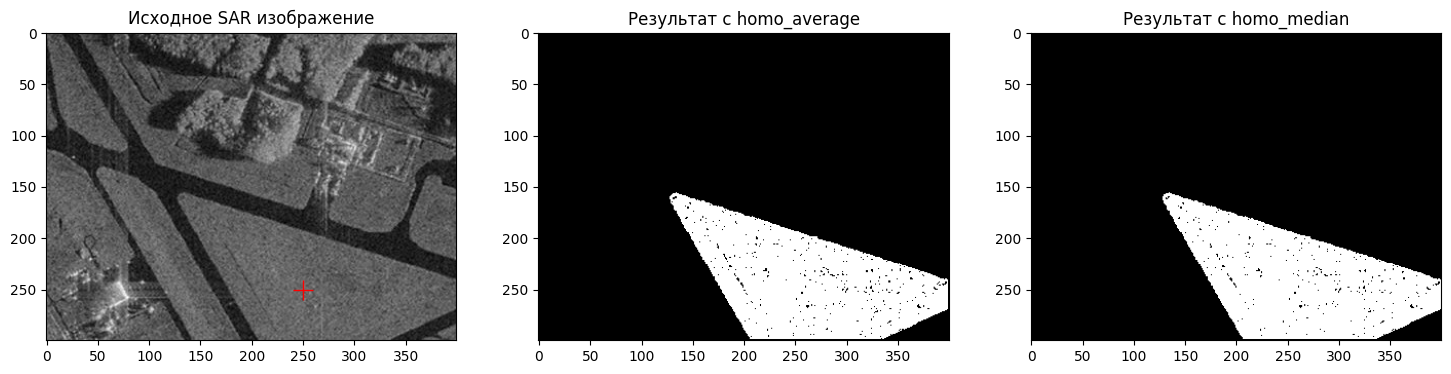

In [3]:
def homo_median(img, mask, point, T):
    region_vals = img[mask > 0]

    med_val = np.median(region_vals)

    return abs(med_val - img[point]) <= T

print(f"Запуск с исходной функцией 'homo_average' (T=20)")
mask_avg = region_growing(image_sar_gray, seed_point_lawn, homo_average, radius, threshold_lawn)
    
print(f"Запуск с новой функцией 'homo_median'")
mask_med = region_growing(image_sar_gray, seed_point_lawn, homo_median, radius, 20)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title('Исходное SAR изображение')
plt.imshow(image_sar_gray, cmap="gray")
plt.plot(seed_point_lawn[1], seed_point_lawn[0], 'r+', markersize=15)
    
plt.subplot(1, 3, 2)
plt.title(f'Результат с homo_average')
plt.imshow(mask_avg, cmap="gray")
    
plt.subplot(1, 3, 3)
plt.title(f'Результат с homo_median')
plt.imshow(mask_med, cmap="gray")
    
#Критерий медиана более точно вычисляет, быстрее


РЕЗУЛЬТАТ: Количество найденных деревьев: 101


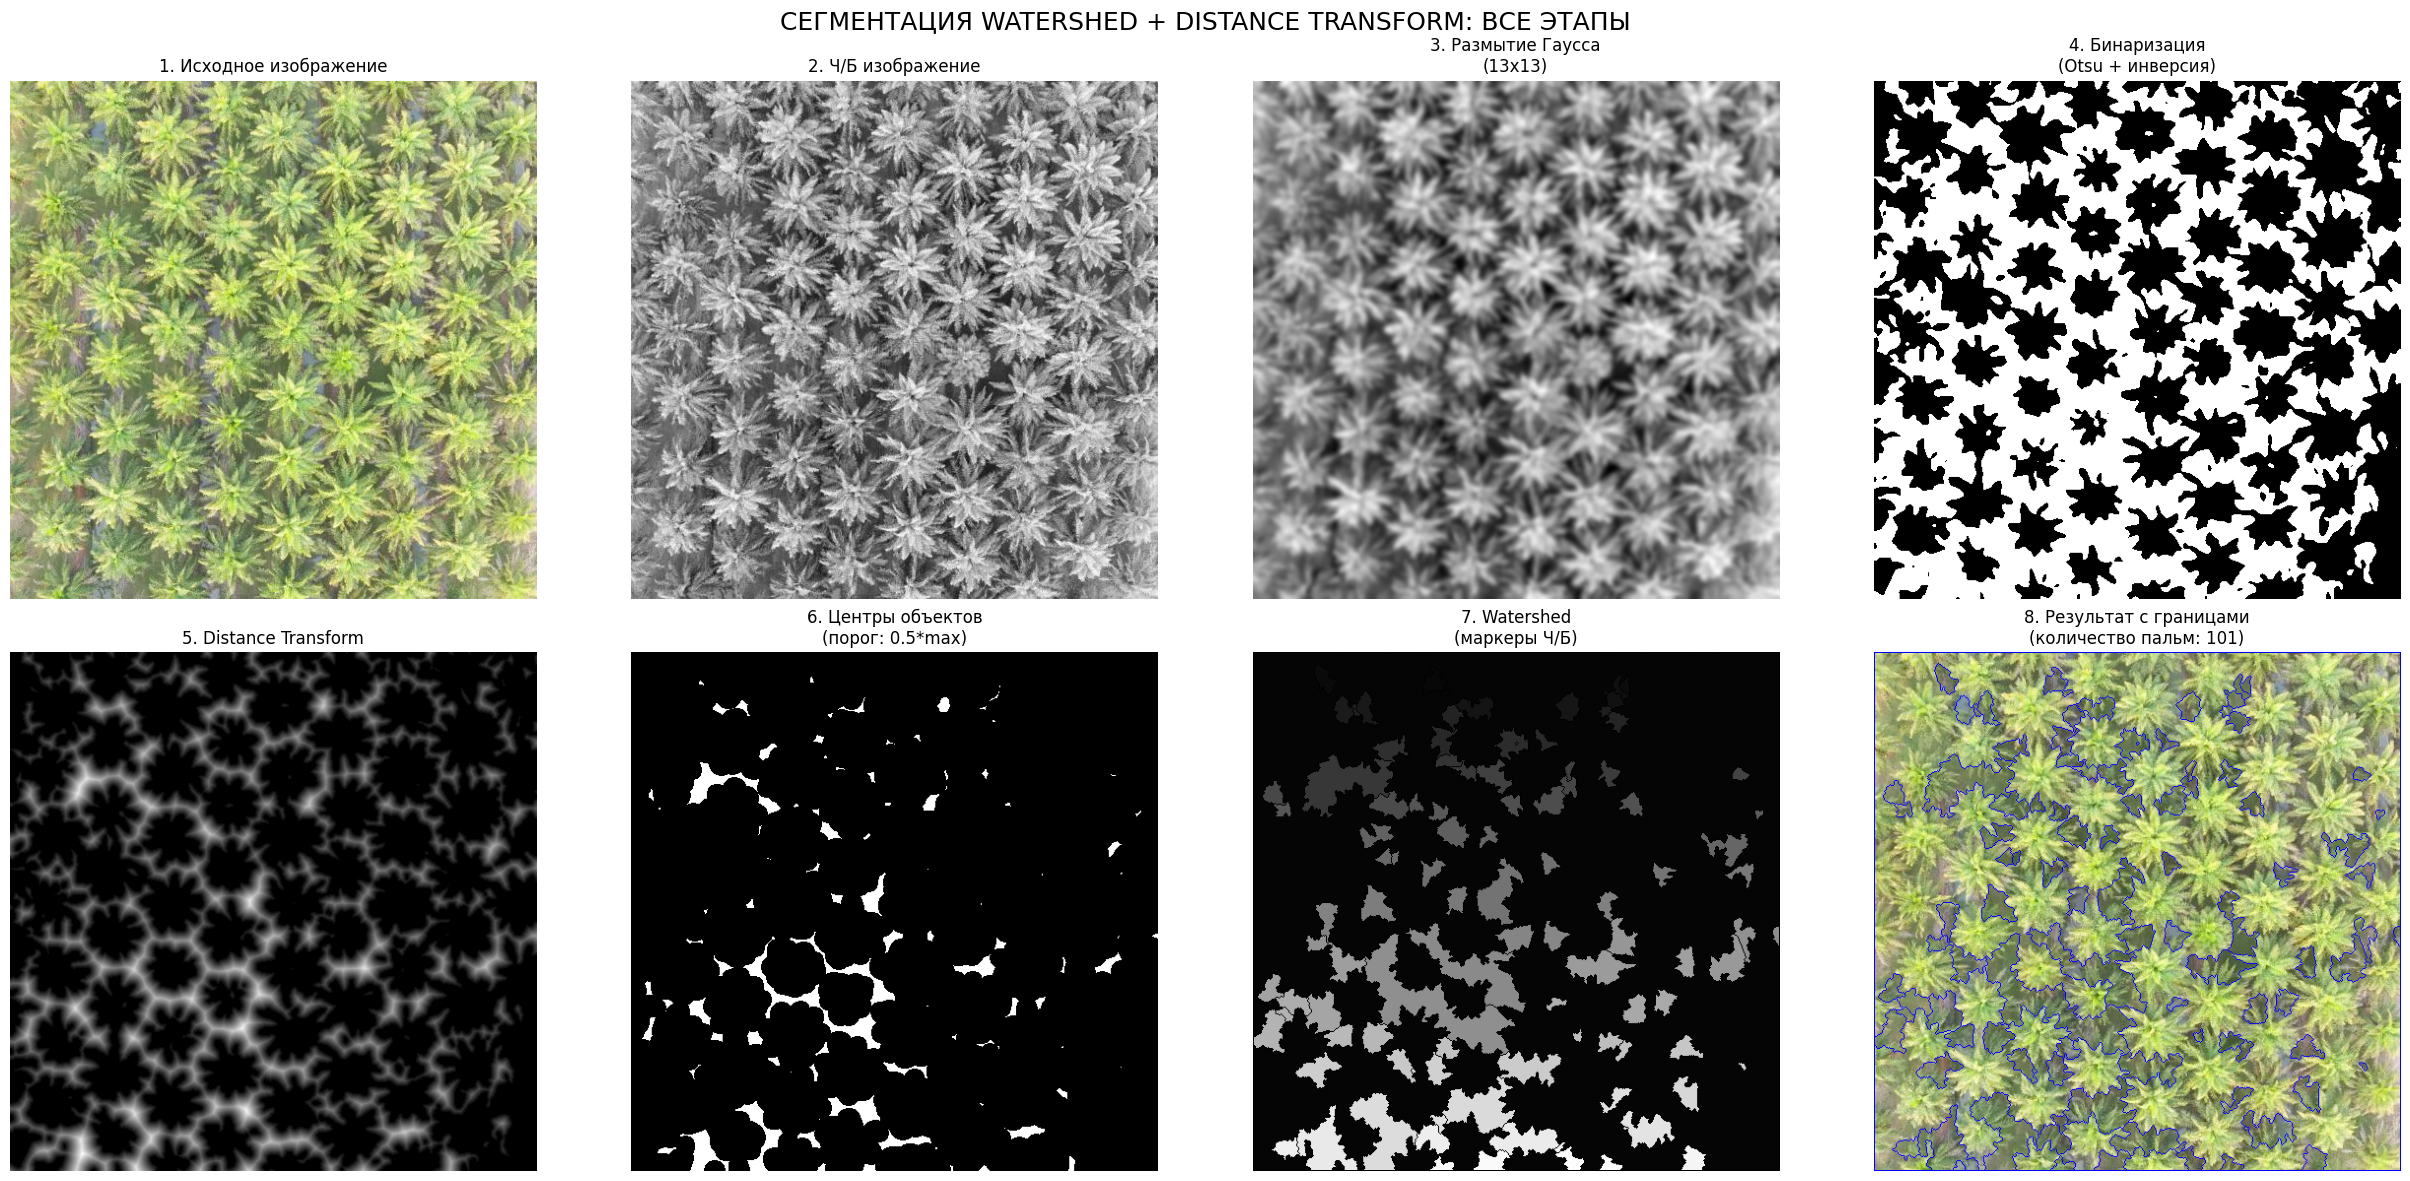

In [ ]:
def watershed_segmentation(image_path, blur_size=13, dist_threshold=0.5):
    image_palms = cv2.imread(image_path)
    
    image_palms_gray = cv2.cvtColor(image_palms, cv2.COLOR_BGR2GRAY)
    
    image_palms_blurred = cv2.GaussianBlur(image_palms_gray, (blur_size, blur_size), 0)
    
    ret, thresh = cv2.threshold(image_palms_blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    
    ret, sure_fg = cv2.threshold(dist_transform, dist_threshold * dist_transform.max(), 255, cv2.THRESH_BINARY)
    sure_fg = sure_fg.astype(np.uint8)
    
    unknown = cv2.subtract(thresh, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    
    markers_watershed = cv2.watershed(image_palms, markers)
    
    num_palms = len(np.unique(markers_watershed)) - 1
    
    segmented_image = image_palms.copy()
    segmented_image[markers_watershed == -1] = [255, 0, 0]
    
    print(f"РЕЗУЛЬТАТ: Количество найденных деревьев: {num_palms}")
    
    return {
        'original': image_palms,
        'gray': image_palms_gray,
        'blurred': image_palms_blurred,
        'binary': thresh,
        'distance_transform': dist_transform,
        'foreground': sure_fg,
        'markers': markers_watershed,
        'result': segmented_image,
        'count': num_palms
    }

results = watershed_segmentation("palm_1.JPG", blur_size=13, dist_threshold=0.5)

plt.figure(figsize=(25, 12))

plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(results['original'], cv2.COLOR_BGR2RGB))
plt.title("1. Исходное изображение")
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(results['gray'], cmap='gray')
plt.title("2. Ч/Б изображение")
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(results['blurred'], cmap='gray')
plt.title("3. Размытие Гаусса\n(13x13)")
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(results['binary'], cmap='gray')
plt.title("4. Бинаризация\n(Otsu + инверсия)")
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(results['distance_transform'], cmap='gray')
plt.title("5. Distance Transform")
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(results['foreground'], cmap='gray')
plt.title("6. Центры объектов\n(порог: 0.5*max)")
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(results['markers'], cmap='gray')
plt.title("7. Watershed\n(маркеры Ч/Б)")
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(cv2.cvtColor(results['result'], cv2.COLOR_BGR2RGB))
plt.title(f'8. Результат с границами\n(количество пальм: {results["count"]})')
plt.axis('off')

plt.suptitle("СЕГМЕНТАЦИЯ WATERSHED + DISTANCE TRANSFORM: ВСЕ ЭТАПЫ", fontsize=18)
plt.tight_layout()
plt.show()

In [5]:
# ДЗ
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.